In [ ]:
import seaborn as sns

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
change_df = pd.read_csv('../datasets/group_people.csv')
bots_df = pd.read_csv('../datasets/bots.csv')
users_df = pd.read_csv('../datasets/users.csv')
data = pd.concat([bots_df, users_df, change_df])
data = data.fillna(0)


source_features = ['has_photo','has_mobile','is_friend','can_post','can_see_all_posts',
            'can_see_audio','can_write_private_message','can_send_friend_request',
            'can_be_invited_group','followers_count','blacklisted','blacklisted_by_me',
            'is_favorite','is_hidden_from_feed','common_count','university','faculty',
            'graduation','relation','verified','deactivated','friend_status','can_access_closed',
            'is_closed', 'city_id','country_id','last_seen_platform','last_seen_time',
            'interests_bool', 'books_bool', 'tv_bool', 'quotes_bool', 'about_bool',
            'games_bool', 'movies_bool', 'activities_bool', 'music_bool', 'mobile_phone_bool',
            'home_phone_bool', 'site_bool', 'status_bool', 'university_bool',
            'university_name_bool', 'faculty_bool', 'faculty_name_bool', 'graduation_bool',
            'home_town_bool', 'relation_bool', 'personal_bool', 'universities_bool',
            'schools_bool', 'occupation_bool', 'education_form_bool', 'education_status_bool',
            'relation_partner_bool', 'skype_bool', 'twitter_bool', 'livejournal_bool',
            'instagram_bool', 'facebook_bool', 'facebook_name_bool', 'relatives_in_friends_bool',
            'change_nickname_bool', 'partner_in_friends_bool', 'partner_in_friends_bool',
            'posts_count', 'users_subscriptions_count', 'groups_subscriptions_count',
            'albums_count', 'audios_count', 'gifts_count', 'pages_count', 'photos_count',
            'subscriptions_count', 'videos_count', 'video_playlists_count', 'subscriptions_followers_coef',
            'subscriptions_followers_coef_norm', 'friends_count', 'bots']


# Matrix correlation

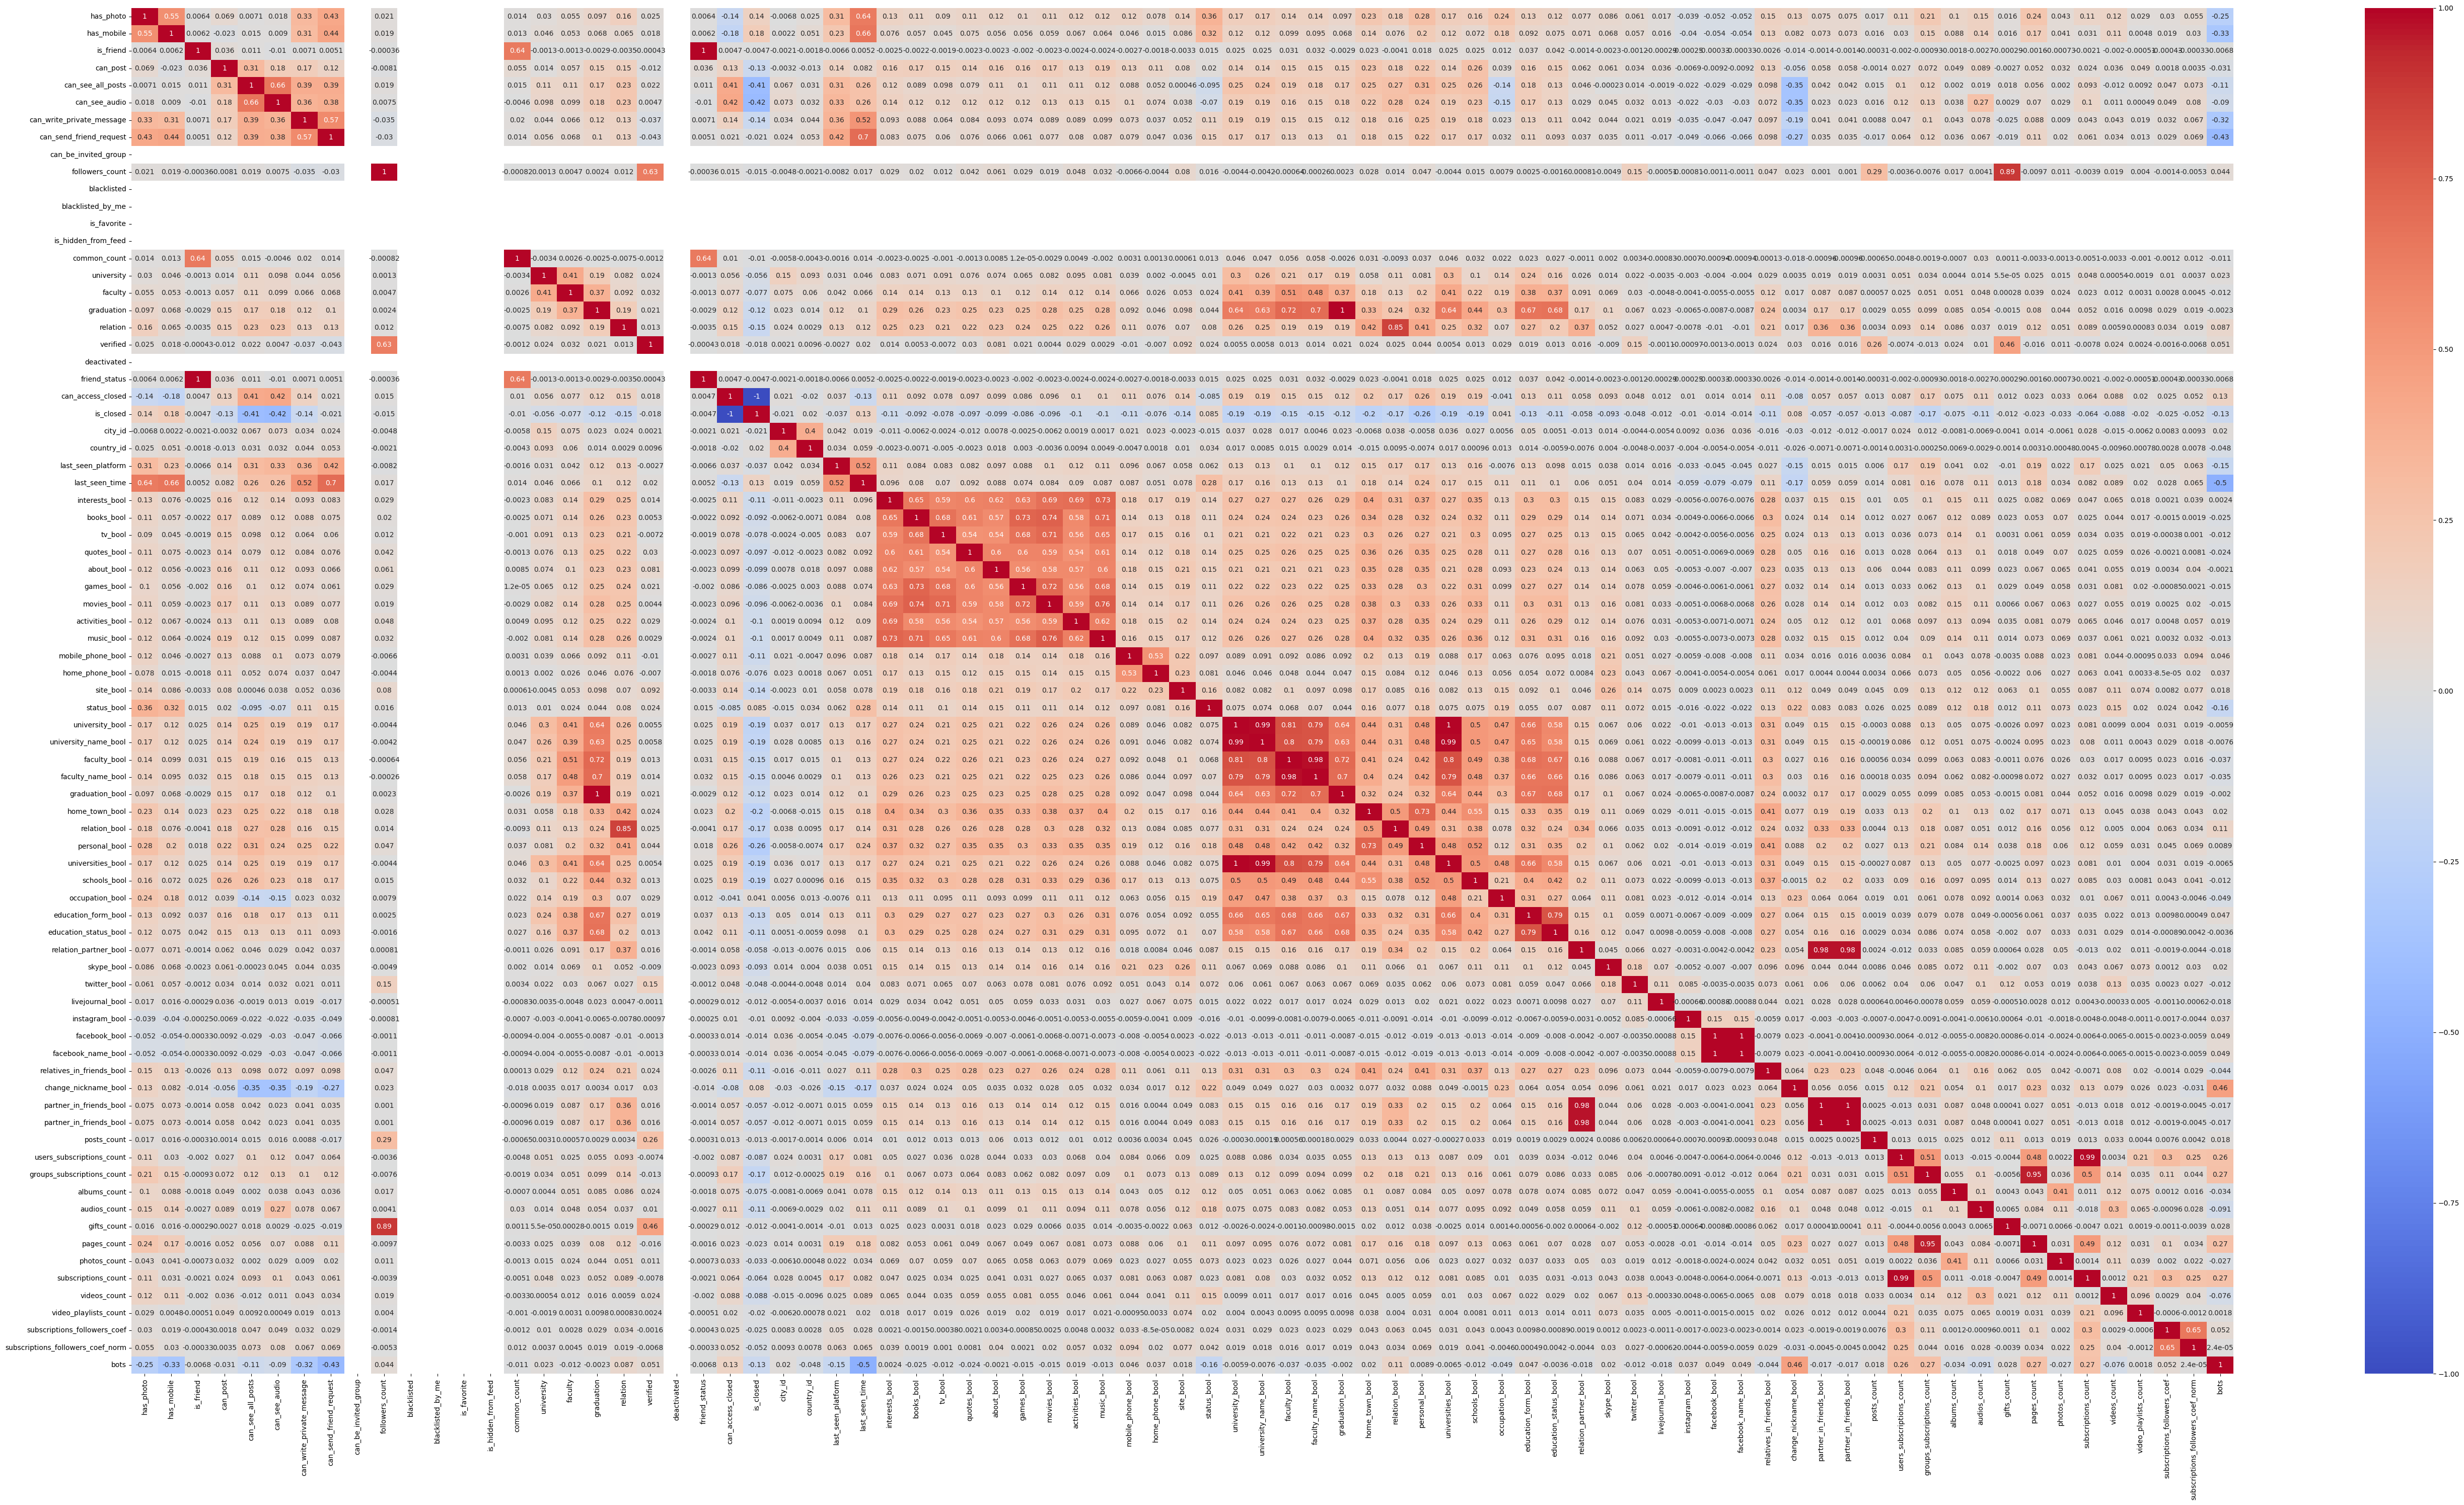

In [85]:
data = data[source_features]
corr_matrix = data.corr()

plt.figure(figsize=(55,30))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.tight_layout()
plt.savefig('Corr_matrix/heatmap.png', dpi=300)

In [86]:
significant_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            colname = corr_matrix.columns[i]
            significant_features.append(colname)
print(significant_features)

['friend_status', 'is_closed', 'last_seen_time', 'games_bool', 'movies_bool', 'movies_bool', 'movies_bool', 'music_bool', 'music_bool', 'music_bool', 'university_name_bool', 'faculty_bool', 'faculty_bool', 'faculty_bool', 'faculty_name_bool', 'faculty_name_bool', 'faculty_name_bool', 'graduation_bool', 'graduation_bool', 'relation_bool', 'personal_bool', 'universities_bool', 'universities_bool', 'universities_bool', 'universities_bool', 'education_status_bool', 'facebook_name_bool', 'partner_in_friends_bool', 'partner_in_friends_bool', 'partner_in_friends_bool', 'gifts_count', 'pages_count', 'subscriptions_count']


In [87]:
class Result:
    def __init__(self, clf, accuracy, precision, recall, auc, f1, fpr, tpr):
        self.clf = clf
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.auc = auc
        self.f1 = f1
        self.fpr = fpr
        self.tpr = tpr
    
    @property
    def metrics_sum(self):
        return self.accuracy + self.precision + self.recall + self.auc + self.f1

In [88]:
X, y = data[significant_features], data[["bots"]].values.flatten()

clfs = [
    DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10),
    RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20),
    LogisticRegression(random_state=0),
    svm.SVC(probability=True),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000),
    GaussianNB(),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
    HistGradientBoostingClassifier()
]
results = []
for clf in clfs:
    # Разделение данных на train и test
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y)

    # Обучаем классификатор
    clf.fit(Xtrain, Ytrain)

    # Предсказываем y
    y_pred_test = clf.predict(Xtest)

    # Вычисляем метрики
    test_accuracy = accuracy_score(y_pred_test, Ytest)
    test_precision = precision_score(y_pred_test, Ytest)
    test_recall = recall_score(y_pred_test, Ytest)
    test_f1 = f1_score(y_pred_test, Ytest)

    y_true = Ytest
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_test)
    test_auc = auc(fpr, tpr)

    result = Result(clf, test_accuracy, test_precision, test_recall, test_auc, test_f1, fpr, tpr)
    results.append(result)
    print(clf)
    print(f"F1 score: {f1_score(y_pred_test, Ytest)}")
    print(f"Recall score: {recall_score(y_pred_test, Ytest)}")
    print(f"Precision score: {precision_score(y_pred_test, Ytest)}")
    print(f"Accuracy score: {accuracy_score(y_pred_test, Ytest)}")
    print(f"Auc score: {test_auc}")
    print()

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50,
                       min_samples_split=10)
F1 score: 0.7833474936278675
Recall score: 0.8474264705882353
Precision score: 0.7282780410742496
Accuracy score: 0.8864648263579697
Auc score: 0.8384105642445024

RandomForestClassifier(criterion='entropy', min_samples_leaf=100,
                       min_samples_split=20)
F1 score: 0.7717099373321398
Recall score: 0.8850102669404517
Precision score: 0.6841269841269841
Accuracy score: 0.8864648263579697
Auc score: 0.8247367593902247

LogisticRegression(random_state=0)
F1 score: 0.5682507583417594
Recall score: 0.8977635782747604
Precision score: 0.4156804733727811
Accuracy score: 0.8098842386464826
Auc score: 0.6976491538838427

SVC(probability=True)
F1 score: 0.5865580448065173
Recall score: 0.891640866873065
Precision score: 0.4370257966616085
Accuracy score: 0.8192341941228851
Auc score: 0.7074858031827261



/Users/antonkondrahin/Library/Caches/pypoetry/virtualenvs/vk-users-cVe5n_Bl-py3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=1000,
              random_state=1, solver='lbfgs')
F1 score: 0.4503127171646978
Recall score: 0.29110512129380056
Precision score: 0.9938650306748467
Accuracy score: 0.2956366874443455
Auc score: 0.5019513359145877

GaussianNB()
F1 score: 0.6161719549641761
Recall score: 0.887905604719764
Precision score: 0.4717868338557994
Accuracy score: 0.8330365093499554
Auc score: 0.7240774965298897

AdaBoostClassifier(n_estimators=100, random_state=0)
F1 score: 0.7990155865463495
Recall score: 0.8573943661971831
Precision score: 0.7480798771121352
Accuracy score: 0.8909171861086376
Auc score: 0.848648089026287

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
F1 score: 0.7922392886014551
Recall score: 0.8703374777975134
Precision score: 0.7270029673590505
Accuracy score: 0.8855743544078362
Auc score: 0.8402826541629858

HistGradientBoostingClassifier()
F1 score: 0.8323793949304988
Recall score: 0.90892857142

# Plot graphs of metrics

/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_27964/104612921.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(clfs_names, rotation=90)
/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_27964/104612921.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(clfs_names, rotation=90)
/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_27964/104612921.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(clfs_names, rotation=90)
/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_27964/104612921.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(clfs_names, rotation=90)
/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_27964/104612921.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height sm

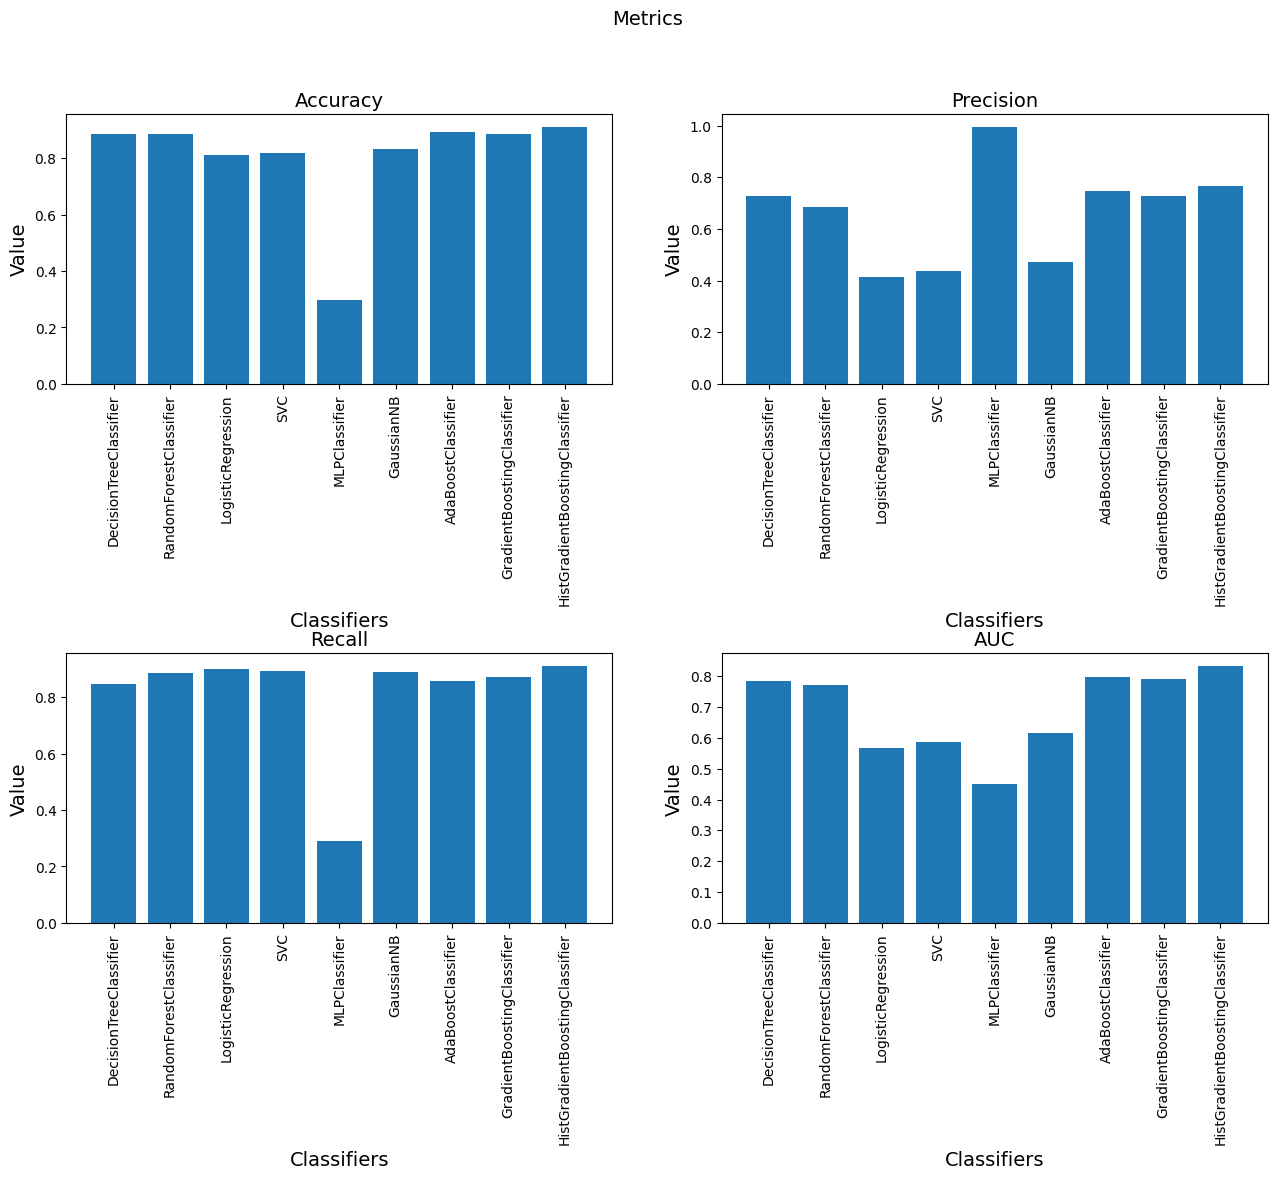

In [89]:
# Строим график столбцов
accuracy_values = [result.accuracy for result in results]
precision_values = [result.precision for result in results]
recall_values = [result.recall for result in results]
auc_values = [result.auc for result in results]
f1_values = [result.f1 for result in results]

# Добавляем заголовок и подписи осей
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=1)

clfs_names = [result.clf.__class__.__name__ for result in results]
# Первый график
axs[0, 0].bar(clfs_names, accuracy_values)
axs[0, 0].set_title('Accuracy', fontsize=14)
axs[0, 0].set_xlabel('Classifiers', fontsize=14)
axs[0, 0].set_ylabel('Value', fontsize=14)
axs[0, 0].set_xticklabels(clfs_names, rotation=90)

# Второй график
axs[0, 1].bar(clfs_names, precision_values)
axs[0, 1].set_title('Precision', fontsize=14)
axs[0, 1].set_xlabel('Classifiers', fontsize=14)
axs[0, 1].set_ylabel('Value', fontsize=14)
axs[0, 1].set_xticklabels(clfs_names, rotation=90)
# Третий график
axs[1, 0].bar(clfs_names, recall_values)
axs[1, 0].set_title('Recall', fontsize=14)
axs[1, 0].set_xlabel('Classifiers', fontsize=14)
axs[1, 0].set_ylabel('Value', fontsize=14)
axs[1, 0].set_xticklabels(clfs_names, rotation=90)
# Четвертый график
axs[1, 1].bar(clfs_names, f1_values)
axs[1, 1].set_title('AUC', fontsize=14)
axs[1, 1].set_xlabel('Classifiers', fontsize=14)
axs[1, 1].set_ylabel('Value', fontsize=14)
axs[1, 1].set_xticklabels(clfs_names, rotation=90)
# Настраиваем расположение графиков и добавляем общий заголовок
fig.tight_layout()
fig.suptitle('Metrics', fontsize=14)

# Сохраняем график
fig.set_size_inches(15.5, 10.5, forward=True)
fig.savefig('Metrics.png', dpi=300)
plt.show()

# Plot ROC curves

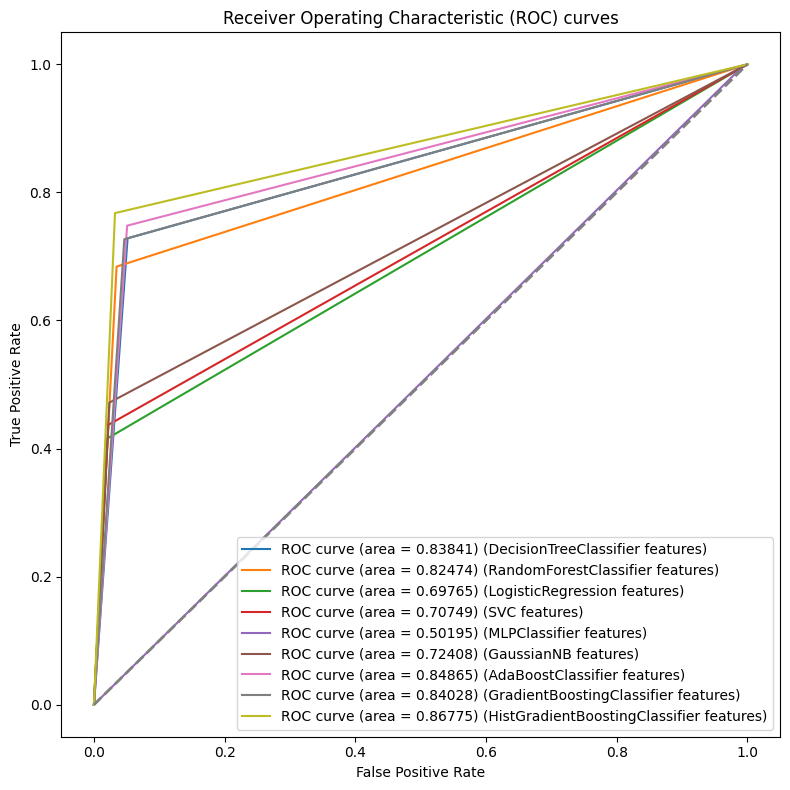

In [90]:
fig = plt.figure(figsize=(8, 8))

# Строим ROC кривые
for i in range(len(results)):
    plt.plot(
        results[i].fpr,
        results[i].tpr,
        label=f'ROC curve (area = %0.5f) ({results[i].clf.__class__.__name__} features)'% results[i].auc
    )

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curves')
plt.legend(loc="lower right")

# Сохраняем график
fig.tight_layout()
plt.savefig('ROC-curves.png', dpi=300)
plt.show()